In [ ]:
# Colab 구글드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 라이브러리 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

---

# 0. 큰 그림 보기

> 목적 : 캘리포니아 인구조사 데이터를 사용해 캘리포니아의 주택 가격 모델을 만드는 것
- 주어진 데이터로 모델을 학습시켜 다른 데이터가 주어졌을 때 해당 구역의 중간 주택 가격을 예측

> 문제 정의
- 지도 학습 : 레이블된 훈련 샘플이 있음
- 다중 회귀 : 여러 개의 특성을 이용하여 값을 예측
    - 단변량 회귀 : 각 구역마다 하나의 값을 예측
- 배치 학습 : 시스템으로 들어오는 데이터에 연속적인 흐름이 없음

> 데이터 구조
- longitude : 경도
- latitude : 위도
- housing_median_age : 주택 연식
- total_romms : 총 방 수
- total_bedrooms : 총 침실 수
- population : 인구
- median_income : 중간 소득
- median_house_value : 중간 주택 가격
- ocean_proximity : 인근의 바다

> 기타 정보
- 블록 그룹은 미국 인구조사국에서 샘플 데이터를 발표하는 데 사용하는 최소한의 지리적 단위이다.
    - 하나의 블록 그룹은 보통 600~3,000명의 인구를 나타낸다.

# 1. 데이터 불러오기

In [ ]:
base_path = '/content/drive/MyDrive/공부 파일/코딩 공부/HandsOn-ML2/실습 코드 모음/Ch2. 머신러닝 프로젝트 처음부터 끝까지/data'
data = base_path + '/housing.csv'
housing = pd.read_csv(data)

# 2. 데이터 구조 훑어보기

In [ ]:
housing.head(5)  # 데이터의 첫 5행 확인

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing.info()  # 데이터의 정보 요약

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


> 알 수 있는 정보
- 총 데이터의 정보 - row : 20640행 / column : 10개
- ocean_proximity를 제외한 모든 특성은 숫자이다.
- total_bedrooms에는 207개의 null value가 확인된다.

In [ ]:
housing.ocean_proximity.unique()  # ocean_proximity column 확인

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [ ]:
housing.value_counts('ocean_proximity')  # 각 카테고리별 갯수 확인

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
dtype: int64

> ocean_proximity는 5가지 값이 반복적으로 존재하는 걸로 보아 범주형 변수로 생각된다.

In [ ]:
housing.describe()  # 숫자형 특성의 요약 정보(기술통계량) 확인

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


> 데이터의 형태를 빠르게 볼 수 있는 방법 중 하나는 각 숫자형 특성을 히스토그램으로 그려보는 것이다.

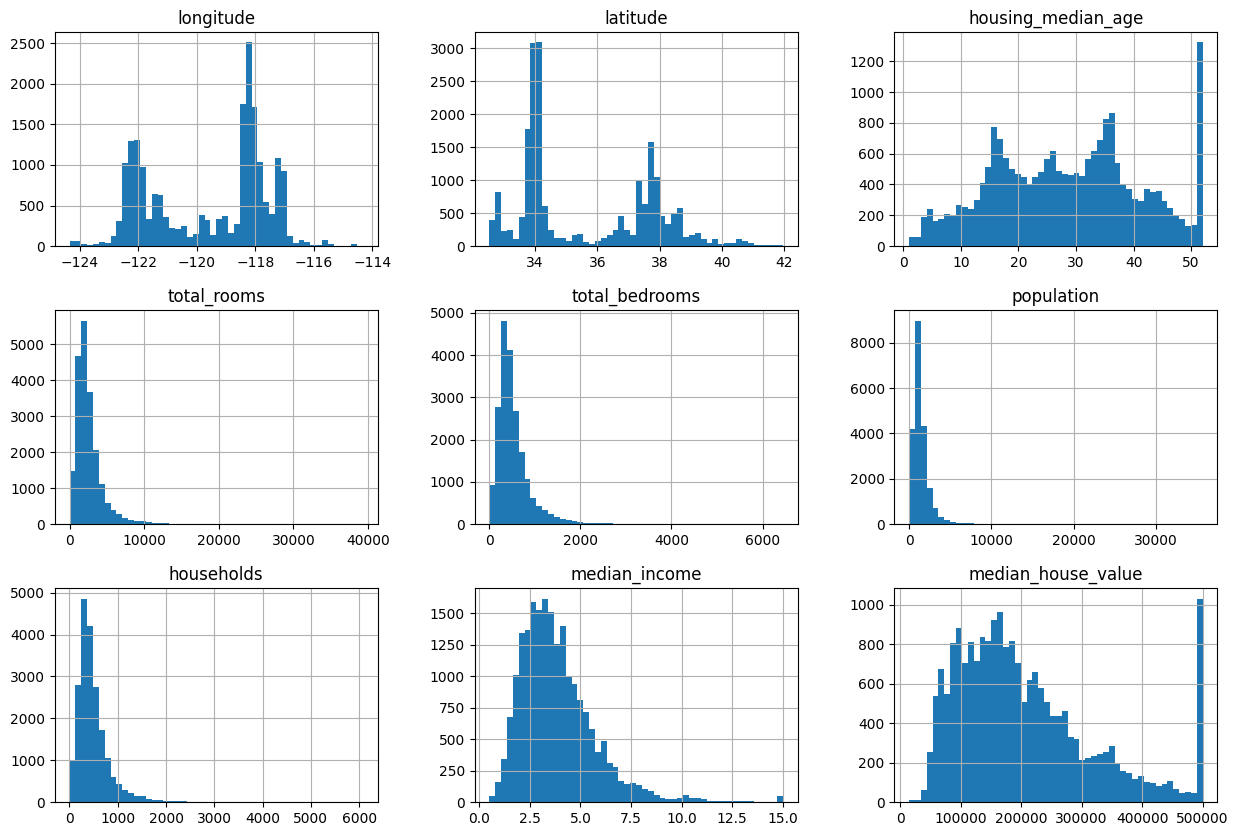

In [ ]:
housing.hist(bins=50, figsize=(15, 10))  # 전체 숫자형 특성에 대한 히스토그램 그리기
plt.show()

> 알 수 있는 정보
1. median_income은 데이터를 취합하는 과정에서 scale을 조정하여 상한이 15, 하한이 0.5가 되도록 만들었다고 한다.
2. housing_median_age와 median_house_value은 최댓값과 최솟값을 한정했다고 한다(오른쪽 꼬리 분포의 형태이지만 최댓값이 굉장이 높은 걸 확인할 수 있다).
    - median_house_value는 타깃 속성(lable)으로 사용되기 때문에 너무 극단적인 값이 존재할 경우 심각한 문제가 될 수 있다.
    - 만일 극단적이더라도 정확한 예측값이 필요할 경우 다른 방법을 이용해야 한다.<br>
        (1) 한계 밖의 구역에 대한 정확한 레이블을 구한다.<br>
        (2) 훈련 세트에서 해당 구역을 제거한다.
3. 특성들 간의 스케일에 차이가 크다.

# 3. 테스트 세트 만들기

> 모든 데이터를 학습에 사용하거나, 테스트 세트를 분석하여 데이터의 경향성을 알게 될 경우 해당 데이터에 적합한 모델을 만드는 과정에서 과적합이 발생할 수 있다.<br>
이러한 현상을 `데이터 스누핑 편향(data snooping bias)`이라고 한다.<br>
데이터 스누핑 편향을 방지하며 일반화 성능이 좋은 모델을 만들기 위해서는 사전에 데이터의 일부를 떼어놓아 테스트 세트를 만드는 등 적절한 통계 및 검증 기법을 사용해야 한다.

In [ ]:
# 단순 랜덤 샘플링(random state를 고정하여 난수 초기값 설정)
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)

In [ ]:
print(len(train_set), len(test_set))

16512 4128


> - 단, 이처럼 단순히 무작위로 샘플링을 할 경우 데이터셋이 충분히 크다면 일반적으로 괜찮으나, 그렇지 않으면 샘플링 편향이 발생할 가능성이 크다.
- 이를 방지하기 위하여 테스트 세트가 전체 데이터를 대표할 수 있도록 각 계층에서 적절한 수의 샘플을 추출하는 `계층적 샘플링`이 이루어져야 한다
    - ex. 전체 인구를 대표할 수 있는 1000명을 선택할 때, 미국 인구의 51.3%가 여성이고, 48.7%가 남성이라면 여성은 513명, 남성은 487명이 되어야 합리적일 것이다.

> - 만일 전문가로부터 이 데이터셋은 median_income이 median_house_value를 예측하는 데 큰 영향을 준다는 이야기를 들었다면, 테스트 세트는 전체 데이터셋에 있는 median_income의 경향성을 잘 대표해야 할 것이다.
    - median_income은 대부분의 데이터가 1~6 정도 사이에 모여 있으나, 일부는 6을 넘기는 경향을 보여준다.<br>이러한 전체적인 경향성을 나타낼 수 있도록 계층 별로 충분한 샘플 수를 가져야 한다.
    - 이때 너무 많은 게층으로 나누면 안 되며, 각 계층은 충분히 커야 한다.<br>(아래의 예시에서는 적절히 임의의 값(5개)으로 나누었다)

In [25]:
housing['income_cat'] = pd.cut(housing['median_income'],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

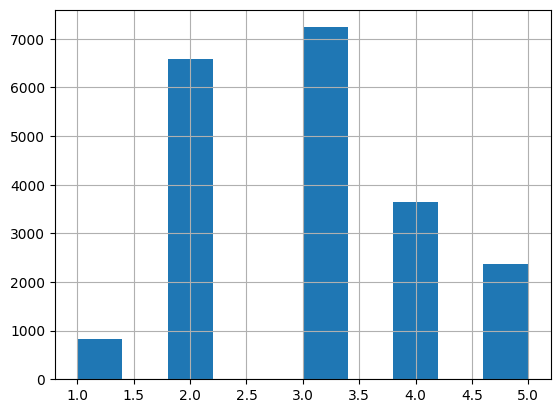

In [26]:
housing['income_cat'].hist()  # median_income 기반의 데이터 분할
plt.show()

In [28]:
# median_income을 기반으로 계층 샘플링
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]) :
    sss_train_set = housing.loc[train_index]
    sss_test_set = housing.loc[test_index]

In [29]:
# 의도대로 잘 분할이 되었는지 확인
sss = sss_test_set['income_cat'].value_counts() / len(sss_test_set)
total = housing['income_cat'].value_counts() / len(housing)

train_set, test_set = train_test_split(housing, test_size = 0.2, random_state=42)
random = train_set['income_cat'].value_counts() / len(train_set)

dic = {'total':total, 'random':random, 'sss':sss}

tp = pd.DataFrame(dic)
tp = tp.sort_index()
tp['random_sampling_error_rate'] = (tp['random'] - tp['total'])/tp['total'] * 100
tp['sss_sampling_error_rate'] = (tp['sss'] - tp['total'])/tp['total'] * 100

tp

,total,random,sss,random_sampling_error_rate,sss_sampling_error_rate
1,0.039826,0.039729,0.039971,-0.243309,0.364964
2,0.318847,0.317466,0.318798,-0.433065,-0.015195
3,0.350581,0.348595,0.350533,-0.566611,-0.013820
4,0.176308,0.178537,0.176357,1.264084,0.027480
5,0.114438,0.115673,0.114341,1.079594,-0.084674


> 랜덤 샘플링과 계층적 샘플링을 비교하였을 때 오류율이 훨씬 줄어듦을 확인할 수 있다!
- 오류율(%) = (관찰값 - 기대값) / 기대값 * 100

In [30]:
# 다음 EDA 과정을 위하여 income_cat의 특성을 삭제하여 원 상태로 돌리기
sss_train_set.drop(columns=["income_cat"], inplace=True)
sss_test_set.drop(columns=["income_cat"], inplace=True)

# 4. 데이터 이해를 위한 탐색과 시각화(EDA)

> 훈련 세트가 매우 큰 경우 조작을 간단하고 빠르게 하기 위해 탐색을 위한 데이터 세트를 별도로 샘플링하여 볼 수도 있다.
- 여기서는 데이터의 크기가 작으므로 훈련 세트 전체를 사용한다.

In [31]:
housing = sss_train_set.copy()  # 훈련 데이터를 손상시키지 않기 위해 복사본을 만들어서 사용
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN


## 4.1. 지리적 데이터 시각화

> 지리 정보(위도, 경도)가 있으니 모든 구역을 산점도로 만들어서 데이터를 시각화 해보자.

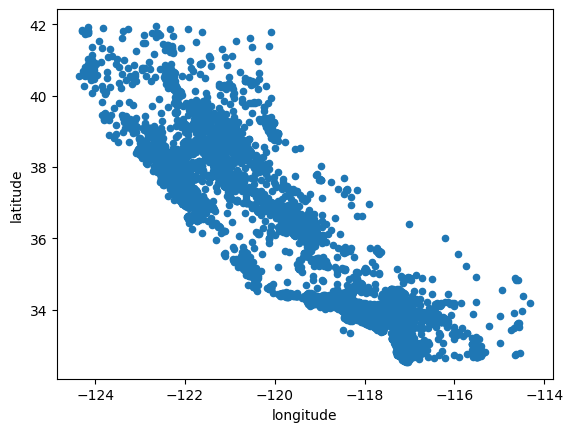

In [32]:
housing.plot(kind='scatter', x='longitude', y='latitude')
plt.show()

> `alpha` 옵션을 낮게 설정하면 보다 밀집된 영역을 확인할 수 있다.
- matplotlib에서 alpha는 **투명도**를 의미한다.

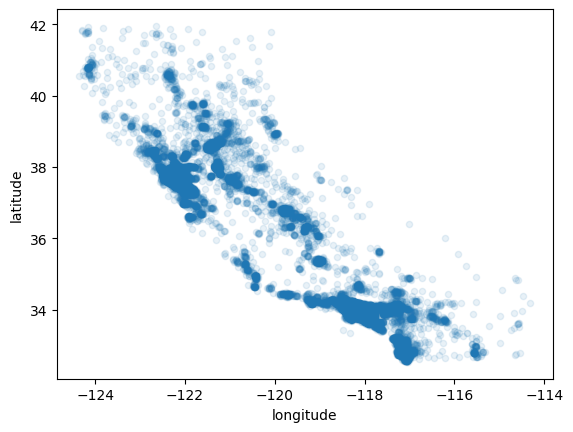

In [33]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1)
plt.show()

> 알수 있는 정보<br>
- 지도로 위치를 확인해보면 특정 지역(Bay Area, Los Angeles, San Diego)에서 부터 근처 지역(Central Valley, Sacramento, Fresno)을 따라 밀집된 장소들이 보인다.

> 더 두드러진 패턴을 파악하기 위해 매개변수를 다양하게 조절해보자.
- 원의 반지름(매개변수 `s`) : 구역의 인구
- 색상(매개변수 `c`) : 가격
- 컬러맵(매개변수 `cmap`) : `jet`(빨간색-파란색)

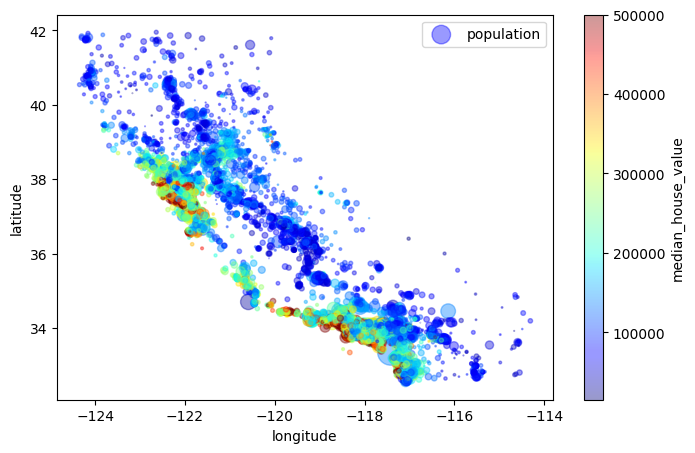

In [34]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.4,
             s=housing['population']/100, label='population', figsize=(8,5),
             c='median_house_value', cmap=plt.get_cmap('jet'), colorbar=True,
             sharex=False    # sharex는 여러 개의 subplot을 그릴 때 x축의 범위를 통일시켜주는 함수이다.
             )
plt.legend()    # matplotlib에서 범례를 추가할 때 legend() 함수를 사용
plt.show()

> 알 수 있는 정보
- 위의 그림을 통해 주택 가격은 지역(ex. 바다와 인접한 곳)과 인구 밀도에 매우 큰 관련이 있다는 사실을 알 수 있다.
- 군집 알고리즘(Clustering)을 통해 주요 군집을 찾고 군집의 중심까지의 거리를 재는 등 해안 근접성 특성이 유용할 수는 있으나, 북부 지역의 해안가는 주택 가격이 그리 높지 않기 때문에 단순하게 규칙을 적용시키기는 어려워 보인다.

## 4.2. 상관관계 조사

> 데이터셋이 너무 크지 않기 때문에 corr() 메소드를 통해 모든 특성 간의 `표준 상관계수(standard correlation coefficient)`/`피어슨 상관계수(r)`를 쉽게 계산할 수 있다.

In [38]:
corr_matrix = housing.corr()

<ipython-input-38-bac487469033>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


In [39]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

> 알 수 있는 정보
- median_income은 양의 상관관게를 보인다.
- total_romms, housing_median_age는 약한 양의 상관관계를 보인다.
- latitude는 약한 음의 상관관게를 보인다.

> 특성 간의 상관관계를 확인하는 또 다른 방법은 숫자형 특성 사이 산점도를 그려보는 것이다.
- 여기서는 숫자형 특성이 9개이므로 그래프가 많이 생기기 때문에 상관관계가 높아 보이는 몇 가지 특성만 살펴보자.

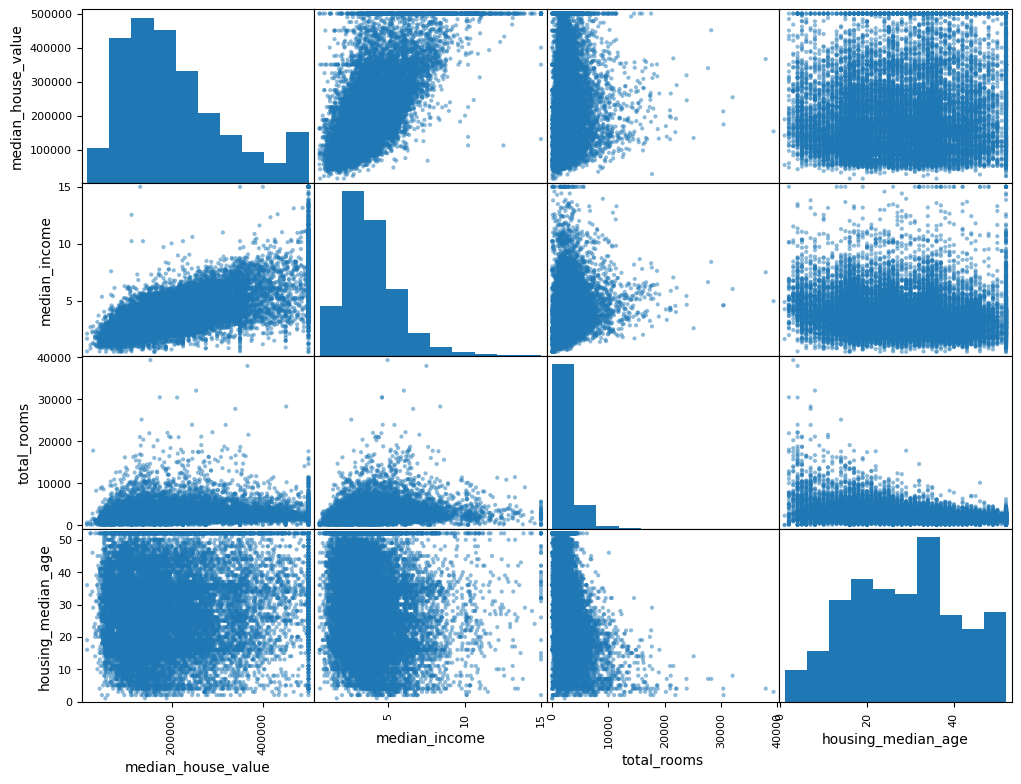

In [41]:
from pandas.plotting import scatter_matrix

attributes = ['median_house_value', 'median_income', 'total_rooms', 'housing_median_age']
scatter_matrix(housing[attributes], figsize=(12,9), )
plt.show()

> mean_house_value을 예측하는 데 가장 유용해 보이는 특성은 median_incomed이므로 따로 떼어내서 보자.

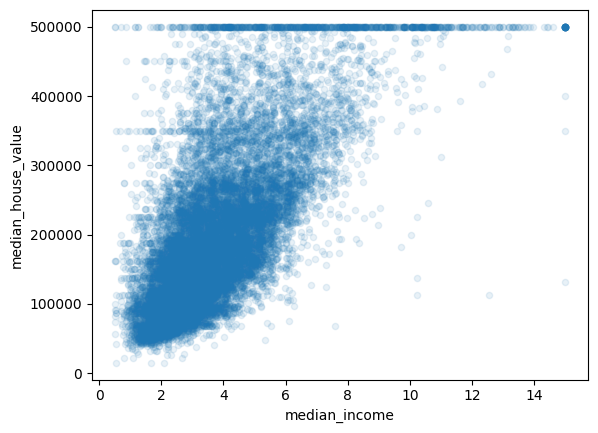

In [43]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.show()

> 알 수 있는 정보
- 상관관계가 매우 강하다.
- 위쪽으로 향하는 경향을 볼 수 있으며, 너무 널리 퍼져 있지 않다.
- 가격 제한값이 $500,000에서 수평선으로 잘 나타난다.
    - $450,000 근처, $350,000 근처에서 약간의 수평선이 보인다.
    - 해당 영역은 알고리즘이 데이터로부터 이상한 형태를 학습하지 않도록 제거해주는 것이 좋다.

## 4.3. 특성 조합으로 실험

> 머신러닝 알고리즘용 데이터를 준비하기 전 이상치 확인, 상관관계 발견에 이어 해볼 수 있는 것은 여러 특성의 조합을 시도해보는 것이다.
- 특정 구역의 방 개수는 얼마나 많은 가구 수가 있는지 모른다면 유용하지 않으므로, 가구당 방 개수를 추가한다.
- 전체 침실의 수도 마찬가지로 방 개수 당 침실의 수가 유용할 것이다.
- 가구당 인원도 흥미로운 특성이 될 수 있을 것 같다.

In [44]:
housing['rooms_per_househole'] = housing.total_rooms / housing.households        # 가구당 방 개수
housing['bedrooms_per_room'] = housing.total_bedrooms / housing.total_rooms      # 방 개수 당 침실의 수
housing['population_per_household'] = housing.population / housing.households    # 가구당 인원 수

In [45]:
housing.head(5)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,rooms_per_househole,bedrooms_per_room,population_per_household
12655,-121.46,38.52,29.0,3873.0,797.0,2237.0,706.0,2.1736,72100.0,INLAND,5.485836,0.205784,3.168555
15502,-117.23,33.09,7.0,5320.0,855.0,2015.0,768.0,6.3373,279600.0,NEAR OCEAN,6.927083,0.160714,2.623698
2908,-119.04,35.37,44.0,1618.0,310.0,667.0,300.0,2.8750,82700.0,INLAND,5.393333,0.191595,2.223333
14053,-117.13,32.75,24.0,1877.0,519.0,898.0,483.0,2.2264,112500.0,NEAR OCEAN,3.886128,0.276505,1.859213
20496,-118.70,34.28,27.0,3536.0,646.0,1837.0,580.0,4.4964,238300.0,<1H OCEAN,6.096552,0.182692,3.167241


In [46]:
# 상관관계 행렬 재확인
corr_matrix = housing.corr()
corr_matrix['median_house_value'].sort_values(ascending=False)

<ipython-input-46-dbe4d79c7cbc>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = housing.corr()


median_house_value          1.000000
median_income               0.687151
rooms_per_househole         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_room          -0.259952
Name: median_house_value, dtype: float64

> 알 수 있는 정보
- 새로 만든 bedrooms_per_room 특성은 total_rooms나 total_bedrooms보다 상관관계가 훨씬 높게 나타났다.
    - 침실/방의 비율이 낮은 집은 더 비싼 경향이 있다.
- rooms_per_household 특성도 total_rooms보다 더 유용하다.
    - 가구당 방의 갯수가 많을수록 더 비싼 경향이 있다.

> EDA 단계는 완벽한 과정이 아니다.<br>
시작을 잘해서 빠르게 통찰을 얻는다면 프로토타입을 잘 만드는 데 도움이 되지만, 이는 반복적인 과정이다.<br>
프로토타입을 만들고 실행하여 결과를 분석한 후, 더 많은 통찰을 얻고 다시 EDA 단계로 돌아와 반복한다.
- 많은 소프트웨어 프로젝트가 그렇지만, 특히나 머신러닝 프로젝트의 경우 빠른 프로토타이핑과 반본적인 프로세스가 권장된다.

# 5. 데이터 준비

> 머신러닝 알고리즘을 위한 데이터를 준비할 때, 함수를 만들어 자동화하는 것이 좋다.
- 어떠한 데이터셋에 대해서라도 데이터 변환을 쉽게 반복할 수 있다.
- 향후 프로젝트에 사용할 수 있는 변환 라이브러리를 점진적으로 구축하게 된다.
- 실제 시스템에서 알고리즘에 새 데이터를 주입하기 전 변환 작업에 함수를 사용할 수 있다.
- 여러 가지 데이터 변환을 쉽게 시도해볼 수 있고 어떤 조합이 가장 좋은지 확인하기 편하다.

In [47]:
# 예측 변수와 레이블을 분리
housing = sss_train_set.drop('median_house_value', axis=1)
housing_labels = sss_train_set.median_house_value.copy()

## 5.1. 데이터 정제

> 대부분 머신러닝 알고리즘은 누락된 특성을 다루지 못하므로 이를 처리해주어야 한다. 앞서 total_bedrooms 특성 누락된 값이 있었기 때문에 이를 처리하자.
- [옵션1] 해당 구역을 제거
- [옵션2] 전체 특성을 삭제
- [옵션3] 특정 값으로 채우기(0, 평균, 중간값 등)

> [옵션3]의 경우 추후에 시스템을 평가할 때 테스트 세트에 있는 누락된 값을 채워넣기 위해 훈련 세트에서 계산된 값이 필요하므로, 따로 변수를 지정하여 저장해둔다.
- 테스트 세트에서 중간값을 계산하여 채울 경우 훈련 세트에서 학습한 것이 소용없어지므로 주의해야 한다.

In [48]:
housing.dropna(subset=['total_bedrooms'])    # 옵션 1

housing.drop('total_bedrooms', axis=1)       # 옵션 2

median = housing.total_bedrooms.median()     # 옵션 3
housing.total_bedrooms.fillna(median, inplace=True)

> 사이킷런의 SimpleImputer는 누락된 값을 손쉽게 다룰 수 있도록 해준다.

In [49]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
housing_num = housing.drop('ocean_proximity', axis=1)    # 중간값은 수치형 특성에서만 계산될 수 있으므로 범주형 특성 제외
imputer.fit(housing_num)    # imputer 객체를 훈련 데이터에 적용

SimpleImputer(strategy='median')

> imputer는 각 특성의 값을 계산해서 그 결과를 객체의 `statistics_` 속성에 저장한다.
- 지금의 데이터는 total_bedrooms 특성에만 누락된 값이 있지만, 추후 시스템이 서비스될 때 새로운 데이터에서 어떤 값이 누락될지 확신할 수 없으므로 모든 수치형 특성에 imputer를 적용하는 것이 바람직하다.

In [50]:
# imputer와 median()의 값을 확인해보면 동일하다는 것 확인할 수 있다.
print(imputer.statistics_)
print(housing_num.median().values)

[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]
[-118.51      34.26      29.      2119.       433.      1164.
  408.         3.54155]


In [54]:
X = imputer.transform(housing_num)  # 학습된 imputer 객체를 훈련 세트의 누락된 값에 적용

> 단, imputer 객체를 사용하여 누락된 값을 채운 데이터는 넘파이 배열이므로 판다스의 데이터프레임으로 바꿔주어야 한다.

In [55]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [56]:
housing_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


> 모든 변환기는 fit()과 transform()을 연달아 호출하는 것과 동일한 `fit_transform()` 메서드도 가지고 있다.
- 이따금 fit_transform()이 최적화되어 있어서 더 빠르다.

In [57]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')  # 객체 선언
housing_num = housing.drop('ocean_proximity', axis=1)  # 수치형 df 남기기(범주형 제외)
imputed_df = pd.DataFrame(imputer.fit_transform(housing_num), columns=housing_num.columns, index=housing_num.index)  # imputer 생성 및 적용

In [58]:
imputed_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16512 entries, 12655 to 19773
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


## 5.2. 텍스트와 범주형 특성 다루기

> 대부분 머신러닝 알고리즘은 숫자를 다루므로 범주형 특성은 텍스트에서 숫자로 변환해주어야 한다.
- 여기서는 사이킷런의 `OrdinalEncoder` 클래스를 사용하였다.
    - OrdinalEncoder는 2차원 데이터부터 변환이 가능하므로, 만일 1차원 데이터(500,)일지라도 2차원 데이터(500, 1)로 바꿔주도록 하자.

In [59]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


In [60]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()  # 객체 선언
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)  # encoder 생성 및 적용
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [61]:
ordinal_encoder.categories_  # categories_ 인스턴스 변수를 통해 카테고리의 목록을 얻을 수 있다.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

### [추가 학습] 명목형 자료(OrdinalEncoder) vs. 순서형 자료(OneHotEncoder)

> - OrdinalEncoder의 경우 명목형 자료에서의 적용은 적절하지만, 순서가 있는 자료에서는 적절하지 않을 수 있다.
    - bad-average와 bad-excellent 사이는 엄연한 차이가 존재할 것이다.
- 순서형 자료의 경우 카테고리별로 이진 특성을 만드는 `원-핫 인코딩(one-hot encoding)`을 사용한다.
    - 다만, 국가 코드, 직업 등 카테고리 특성이 담을 수 있는 카테고리 수가 많을 경우 원-핫 인코딩은 많은 수의 입력 특성을 만들기 때문에, 이는 훈련을 느리게 하고 성능을 감소시킬 수 있다.
    - 이 경우 범주형 입력값을 관련된 숫자형 특성으로 바꾸거나, 각 카테고리를 임베딩(embedding)하는 등의 방법을 사용한다.
        - 임베딩은 각 카테고리를 학습 가능한 저차원 벡터로 바꾸는 것이다.
        - ex. 국가 코드를 국가의 인구나 1인당 GDP로 바꾼다.

In [62]:
# One-hot encoder 사용 예시
from sklearn.preprocessing import OneHotEncoder
cat_encoder = OneHotEncoder()  # 객체 선언
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)  # encoder 생성 및 적용
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

>원-핫 인코딩의 출력은 넘파이 배열이 아닌, SciPy의 희소 행렬(sparse matrix)이다.
- 수천 개의 카테고리가 있는 범주형 특성일 경우 열이 수 천개인 행렬에서 각 행의 1은 하나뿐이므로 0을 모두 메모리에 저장하는 것은 낭비이다.
- 따라서 희소 행렬을 통해 0이 아닌 원소의 위치만 저장한다.
- 넘파이 배열로 바꾸려면 `toarray()` 메서드를 호출하면 된다.

In [63]:
housing_cat_1hot.toarray()

array([[0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [64]:
cat_encoder.categories_  # 마찬가지 categories_ 인스턴스 변수를 통해 카테고리의 목록을 얻을 수 있다.

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

## 5.3. 나만의 변환기

In [65]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):    # *args나 **kargs가 아니다.
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self    # 더 할 일이 없습니다.
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, rooms_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

## 5.4. 특성 스케일링

> 데이터에 적용할 가장 중요한 변환 중 하나는 특성 스케일링(feature scaling)이다.<br>
몇 가지 트리 기반 알고리즘을 제외한 머신러닝 알고리즘은 feature 간에 sacle이 많이 다를 경우 잘 작동하지 않는다.
- 현재 데이터에서 전체 방 개수의 범위는 6\~39320인 반면, 중간 소득의 범위는 0\~15까지이다.
- 이때 타깃값에 대한 스케일링은 일반적으로 불필요하다.

> Feature scaling의 방법으로 `min-max 스케일링`과 `표준화(standardization)`가 가장 널리 사용된다.
1. `min-max scaling(= 정규화 normalization)`
    - 데이터의 값들이 0~1 범위에 들도록 값을 변환한다.
    - 데이터에서 최솟값을 뺀 후 최댓값과 최솟값의 차이로 나눈다.
    - 사이킷런에서는 이에 해당하는 `MinMaxScaler 변환기`를 제공한다.
    - `feature_range` 매개변수를 조절하여 값의 범위를 변경할 수 있다.
2. `표준화(standardization)`
    - 모든 값의 평균이 0, 분산이 1이 되도록 값을 변환한다.
    - 데이터에서 평균을 뺀 후 표준편차로 나눈다.
    - 사이킷런에서는 이에 해당하는 `StandardScaler 변환기`를 제공한다.
    - min-max scaling과는 달리 범위의 상한과 하한이 없기 때문에 어떤 알고리즘에서는 문제가 될 수도 있다.
        - ex. 신경망은 종종 입력값의 범위가 0~1이 되어야 하는 경우가 있다.
    - 이상치에 영향을 덜 받는다.

> 모든 변환기에서 스케일링은 전체 데이터가 아닌, 훈련 데이터에 대해서만 fit() 메서드를 적용해야 한다.<br>
그 다음 훈련 세트 및 테스트 세트(+ 새로운 데이터)에 대해 transform() 메서드를 사용한다.

## 5.5 변환 파이프라인

> 앞서 살펴본 것처럼 변환 단계가 많기 때문에 변환이 순서대로 실행되어야 한다.<br>
사이킷런에는 연속된 변환을 순서대로 처리할 수 있도록 도와주는 `Pipeline` 클래스가 있다.
- Pipeline은 연속된 단계를 나타내는 이름/추정기 쌍의 목록을 입력으로 받는다.
- 마지막 단계에는 변환기와 추정기를 모두 사용할 수 있지만, 그 외에는 모두 변환기여야 한다.
    - 즉, fit_transform() 메서드를 가지고 있어야 한다.
- 이름은 무엇이든 관계없다.
    - 단, 고유하며 이중 밑줄 문자인 __를 포함하지 않아야 한다.
- Pipeline의 fit() 메서드를 호출하면 모든 변환기의 fit_transform() 메서드를 순서대로 호출하면서 한 단계의 출력을 다음 단계의 입력으로 전달한다.
    - 마지막 단게에서는 fit() 메서드만 호출한다.
    - fit_transform() 메서드가 없다면 fit()과 transform()을 차례로 호출한다.

In [66]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [67]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
        -0.01496682, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.07648537, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.06612715, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
         0.00675931,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.0752091 , -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
        -0.0144558 , -0.12169672]])

### [추가 학습] ColumnTransformer

> 사이킷런 0.20 버전에서 하나의 변환기로 각 열마다 적절한 변환을 적용하여 모든 열을 처리할 수 있도록 `ColumnTransformer` 기능이 추가되었다.
- 수치형 열과 범주형 열에 지정할 변환기를 따로 설정하여 한 번에 변환할 수 있다.

In [71]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)    # 숫자형 column들
cat_attribs = ["ocean_proximity"]  # 범주형 column

# 객체 선언
full_pipeline = ColumnTransformer([
  # ( 이름, 변환기, 변환기가 적용될 열 이름(또는 index) )
    ("num", num_pipeline, num_attribs),
    ("cat", OneHotEncoder(), cat_attribs),
])

housing_prepared = full_pipeline.fit_transform(housing)

In [72]:
housing_prepared

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.        ,
         0.        ,  0.        ],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.26758118, -0.1259716 ,  1.22045984, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ...,  0.        ,
         0.        ,  0.        ],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.        ,
         0.        ,  0.        ],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.        ,
         0.        ,  0.        ]])

# 6. 모델 선택 및 훈련

## 6.1. 훈련 세트에서 훈련하고 평가하기

In [73]:
# 선형 회귀 모델 훈련
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

> 훈련 세트에 있는 몇 개의 샘플에 대하여 학습된 모델을 적용시켜보면, 정확한 예측은 아니지만 모델이 잘 작동함을 알 수 있다.

In [77]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]

some_data_prepared = full_pipeline.transform(some_data)

In [79]:
print("예측:", lin_reg.predict(some_data_prepared))
print("레이블:", list(some_labels))

예측: [ 85749.86374743 305433.2153269  152019.84439021 185977.83516103
 244556.65849285]
레이블: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


> 사이킷런의 `mean_square_error` 함수를 사용하여 전체 훈련 세트에 대한 우리의 모델의 RMSE를 측정해보자.

In [80]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68634.00056099873

> 알 수 있는 정보
- ㅇ